In [15]:
import json
import sys
import numpy as np
from numpy import log, exp, pi
import pandas as pd
import scipy
import scipy.stats as stats
import random
from scipy.stats import gaussian_kde, loguniform
from math import lgamma
from glob import glob
import os
#import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

path = '/Users/chris/Desktop/sculpting/'

In [2]:
berger_kepler = pd.read_csv(path+'berger_kepler_stellar17.csv') # crossmatched with Gaia via Bedell
print(len(berger_kepler))
print(berger_kepler.head())

19969
    kepid           tm_designation  teff  teff_err1  teff_err2   logg  \
0  757280  2MASS J19242289+3633538  6543      162.0     -194.0  4.082   
1  892667  2MASS J19243045+3637186  6609      159.0     -227.0  4.105   
2  892678  2MASS J19243108+3638316  6137      167.0     -186.0  3.936   
3  892713  2MASS J19243353+3637220  6106      186.0     -186.0  3.854   
4  892828  2MASS J19243904+3637166  6691      188.0     -235.0  4.134   

   logg_err1  logg_err2  feh_x  feh_err1  ...  parallax  parallax_err  feh_y  \
0      0.258     -0.172  -0.24      0.25  ...    1.2137        0.0220    NaN   
1      0.246     -0.164  -0.26      0.25  ...    0.8512        0.0154    NaN   
2      0.428     -0.143  -0.26      0.30  ...    1.0236        0.0259    NaN   
3      0.496     -0.124  -0.24      0.30  ...    0.9602        0.0231    NaN   
4      0.209     -0.171  -0.26      0.25  ...    0.9660        0.0143    NaN   

   feh_err    RUWE  num_gaia_companions  Kmag_final_prov  evstate      log

/Users/chris/anaconda2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (138) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# transit multiplicity from Kepler/Gaia Berger et al 2020, plus Bedell, plus Exoplanet Archive
# see isolate_with_bedell.ipynb
pnum = pd.read_csv(path+'pnum_plus_cands.csv')
print(len(pnum))
pnum = pnum.drop_duplicates(['kepid'])
print(len(pnum))
k = pnum.koi_count.value_counts() 
k = pd.Series([len(berger_kepler)-np.sum(k), 244, 51, 12, 8, 1]) 
print(k)

408
316
0    19653
1      244
2       51
3       12
4        8
5        1
dtype: int64


In [6]:
# redo ms because I forgot that I rounded to single decimal beforehand
ms_corrected = []
ms_corrected_for_plotting = []
for gi_m in range(11):
    for gi_b in range(11):
        ms = -1e-9*np.logspace(8,10,11)[gi_m]
        ms_corrected.append(ms)
        ms_for_plotting = np.log10(np.logspace(8,10,11))[gi_m]
        ms_corrected_for_plotting.append(ms_for_plotting)
print(ms_corrected)
print(ms_corrected_for_plotting)

[-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.1584893192461111, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.25118864315095824, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.3981071705534969, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944, -0.6309573444801944

In [21]:
import csv
from ast import literal_eval

with open('simulations_logtime.csv','r') as csvfile: # simulations_w_logslope.csv
    read_csv = csv.reader(csvfile, delimiter='\t')
    read_csv=list(read_csv)

df = pd.DataFrame(read_csv[1:], columns=read_csv[0])
df.lams = df.lams.apply(literal_eval) # convert back from string to list of floats
print(df)
#df.logLs = df.logLs.apply(literal_eval) # convert back from string to list of floats
df.bs = df.bs.apply(literal_eval)
#df.ms = df.ms.apply(literal_eval)
df.ms = ms_corrected
df.intact_fracs = df.intact_fracs.apply(literal_eval)
logLs = df.logLs
lams = df.lams


       ms   bs                                       intact_fracs  \
0    -2.0  0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1    -2.0  0.1  [0.1, 0.09, 0.11, 0.07, 0.14, 0.16, 0.1, 0.1, ...   
2    -2.0  0.2  [0.24, 0.22, 0.21, 0.25, 0.15, 0.21, 0.26, 0.2...   
3    -2.0  0.3  [0.33, 0.32, 0.35, 0.35, 0.31, 0.24, 0.33, 0.3...   
4    -2.0  0.4  [0.41, 0.44, 0.34, 0.43, 0.35, 0.38, 0.43, 0.4...   
..    ...  ...                                                ...   
116   0.0  0.6  [0.65, 0.52, 0.65, 0.63, 0.7, 0.58, 0.54, 0.56...   
117   0.0  0.7  [0.68, 0.76, 0.73, 0.77, 0.68, 0.67, 0.71, 0.6...   
118   0.0  0.8  [0.72, 0.76, 0.81, 0.79, 0.78, 0.82, 0.76, 0.8...   
119   0.0  0.9  [0.87, 0.92, 0.85, 0.88, 0.89, 0.95, 0.91, 0.8...   
120   0.0  1.0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   

                                                 logLs  \
0    [-197.462132380805, -553.1422661227691, -615.3...   
1    [-227.85877670653113, -330.4962881138846, -951... 

In [22]:
print(df.lams[40][0:2])
print(df.logLs[40][0:30])

[[19369.93, 599.0699999999999, 0.0, 0.0, 0.0, 0.0], [19369.93, 399.38, 199.69, 0.0, 0.0, 0.0]]
[-330.4962881138846, -159.2947


In [23]:
def better_loglike(lam, k):
    """
    Calculate Poisson log likelihood
    """
    
    logL = []
    #print(lam)
    for i in range(len(lam)):
        term3 = -lgamma(k[i]+1)
        term2 = -lam[i]
        term1 = k[i]*np.log(lam[i])
        #print(term1, term2, term3)
        logL.append(term1+term2+term3)
    return np.sum(logL)

In [24]:
print(better_loglike(df.lams[40][0], k))

-inf


/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


In [25]:
test_k = [19653, 244, 51, 12, 8, 1]
test_lam = [1000, 718.884, 359.442, 207.67759999999998, 63.9008, 1e-10]
better_loglike(test_lam, test_k)

-40538.56317220582

In [26]:
df

,ms,bs,intact_fracs,logLs,lams,geometric_lams,geometric_logLs,cutoffs
0,-0.1,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-197.462132380805, -553.1422661227691, -615.3...","[[19769.31, 199.69, 0.0, 0.0, 0.0, 0.0], [1877...","[[18970.55, 798.76, 199.69, 0.0, 0.0, 0.0], [1...","[-399.6190979703892, -718.8503232765049, -778....",0.1
1,-0.1,0.1,"[0.1, 0.09, 0.11, 0.07, 0.14, 0.16, 0.1, 0.1, ...","[-227.85877670653113, -330.4962881138846, -951...","[[19569.62, 399.38, 0.0, 0.0, 0.0, 0.0], [1936...","[[18571.17, 1198.1399999999999, 199.69, 0.0, 0...","[-718.8503232765049, -778.7908806318643, -1470...",0.1
2,-0.1,0.2,"[0.24, 0.22, 0.21, 0.25, 0.15, 0.21, 0.26, 0.2...","[-227.85877670653113, -951.3726317654742, -113...","[[19569.62, 399.38, 0.0, 0.0, 0.0, 0.0], [1857...","[[19170.239999999998, 798.76, 0.0, 0.0, 0.0, 0...","[-463.9617160452466, -1219.7206220577818, -113...",0.1
3,-0.1,0.3,"[0.33, 0.32, 0.35, 0.35, 0.31, 0.24, 0.33, 0.3...","[-330.4962881138846, -745.9048495195141, -126....","[[19369.93, 599.0699999999999, 0.0, 0.0, 0.0, ...","[[18970.55, 998.45, 0.0, 0.0, 0.0, 0.0], [1817...","[-615.3071458165424, -1079.360651054333, -434....",0.1
4,-0.1,0.4,"[0.41, 0.44, 0.34, 0.43, 0.35, 0.38, 0.43, 0.4...","[-699.7755891655663, -895.9667512640724, -759....","[[18571.17, 998.45, 199.69, 199.69, 0.0, 0.0],...","[[18371.48, 798.76, 199.69, 199.69, 399.38, 0....","[-918.7702431254362, -1138.5978570001753, -124...",0.1
...,...,...,...,...,...,...,...,...
116,-10.0,0.6,"[0.65, 0.52, 0.65, 0.63, 0.7, 0.58, 0.54, 0.56...","[-286.04848286964096, -903.9247571949718, -112...","[[19369.93, 199.69, 199.69, 0.0, 199.69, 0.0],...","[[18171.79, 798.76, 599.0699999999999, 199.69,...","[-1120.1525801653686, -1530.8517805832175, -22...",0.1
117,-10.0,0.7,"[0.68, 0.76, 0.73, 0.77, 0.68, 0.67, 0.71, 0.6...","[-882.9631882325278, -946.9809308855425, -953....","[[18571.17, 399.38, 599.0699999999999, 0.0, 39...","[[17572.72, 399.38, 998.45, 199.69, 199.69, 59...","[-1878.5771104442883, -1841.8484126220258, -18...",0.1
118,-10.0,0.8,"[0.72, 0.76, 0.81, 0.79, 0.78, 0.82, 0.76, 0.8...","[-434.46301744006655, -1066.1193854514759, -69...","[[18970.55, 599.0699999999999, 399.38, 0.0, 0....","[[18571.17, 599.0699999999999, 599.06999999999...","[-789.5748792986155, -1247.9313098178882, -960...",0.1
119,-10.0,0.9,"[0.87, 0.92, 0.85, 0.88, 0.89, 0.95, 0.91, 0.8...","[-621.754491599597, -1243.6782905260013, -320....","[[18770.86, 599.0699999999999, 599.06999999999...","[[17173.34, 1397.83, 599.0699999999999, 599.06...","[-2081.057448750574, -2322.6917432455016, -665...",0.1


In [27]:
logLs = df.logLs
lams = df.lams

In [28]:
def kde_func(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    kde = gaussian_kde(x) # constant bandwidth so imbalance in sample size doesn't drive distribution
    return kde.evaluate(x_grid)

def prior_grid(cube, ndim, nparams, gi_m, gi_b):
    """
    Each model run will use an evenly spaced (m,b) tuple on a discrete 11x11 grid
    Does that ruin the point of multinest? Is it valid without random sampling? 
    Maybe so, but pymultinest keeps getting stuck, so I need to get a better sense of the logL surface.
    gi_m: grid index on m axis
    gi_b: grid index on b axis
    """
    cube[0] = np.linspace(-1,0,11)[gi_m]
    cube[1] = np.linspace(0,1,11)[gi_b]
    return cube

def generate_rand_from_pdf(pdf, x_grid, n):
    cdf = np.cumsum(pdf) # create cdf
    cdf = cdf / cdf[-1] # normalize cdf
    values = np.random.rand(n) 
    value_bins = np.searchsorted(cdf, values) # return positions in cdf vector where random values should go
    random_from_cdf = x_grid[value_bins] # select x_d positions based on these random positions
    return random_from_cdf

def kde(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    #kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=0)) # ddof=1 means std divisor is N-1 instead of N
    #kde = gaussian_kde(x, bw_method=np.power(len(x), -0.2)) # ddof=1 means std divisor is N-1 instead of N
    kde = gaussian_kde(x, bw_method=0.15) # constant bandwidth so imbalance in sample size doesn't drive distribution
    #print(bandwidth/x.std(ddof=1)) # this is bw used in S/O
    #print(np.power(len(x), -0.2)) # the bw if I use Scott's factor as the bw to multiply with covariance matrix
    return kde.evaluate(x_grid)

plt.figure(figsize=(16,16))
index = 0
ndim = 2
nbins = 20
nparams = 2
draws = 50
lower = min([min(i) for i in logLs])
upper = max([max(i) for i in logLs])
logLs = df.fixed_logLs
lams = df.fixed_lams
bs = df.bs
ms = df.ms
mean_logLs = []
mean_logLs2 = []
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        cube = [random.uniform(0,1), random.uniform(0,1)]
        cube = prior_grid(cube, ndim, nparams, gi_m, gi_b)
        ax.text(0.2, 0.9, round(cube[0],1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, round(cube[1],1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        hist, bins = np.histogram(logLs[index], bins=20)
        
        x_grid = np.linspace(lower, upper, 100)
        kdepdf = kde_func(np.array(logLs[index]), x_grid, bandwidth=0.2) # generate KDE model
        mean_logLs.append(x_grid[np.argmax(kdepdf)])
        mean_logLs2.append(np.mean(logLs[index]))
        #random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
        #print(kdepdf)
        
        bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
        random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from histogram
        
        #plt.hist(logLs[index], bins=np.linspace(lower, upper, 20))
        ax.hist(logLs[index], nbins, density=True, alpha=0.5) # plot histogram of normalized data
        ax.plot(x_grid, kdepdf, color='r', alpha=0.5, lw=1) # plot KDE over normalized histogram
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
plt.show()

AttributeError: 'DataFrame' object has no attribute 'fixed_logLs'

<Figure size 1152x1152 with 0 Axes>

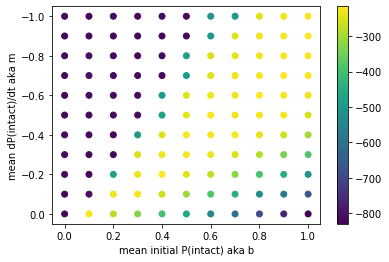

In [15]:
plt.scatter(bs, ms, c=mean_logLs)
plt.xlabel('mean initial P(intact) aka b')
plt.ylabel('mean dP(intact)/dt aka m')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

In [16]:
nonzero_k = k[1:]
print(nonzero_k)

1    244
2     51
3     12
4      8
5      1
dtype: int64


In [17]:
df

,ms,bs,intact_fracs,logLs,lams,fixed_lams,fixed_logLs
0,-1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -in...","[[19256.0, 669.0, 44.0, 0.0, 0.0, 0.0], [19250...","[[19256.0, 669.0, 44.0, 1e-12, 1e-12, 1e-12], ...","[-806.7513443330784, -809.9130482406594, -785...."
1,-1.0,0.1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -in...","[[19276.0, 639.0, 54.0, 0.0, 0.0, 0.0], [19238...","[[19276.0, 639.0, 54.0, 1e-12, 1e-12, 1e-12], ...","[-787.0997072541483, -817.0971154538378, -811...."
2,-1.0,0.2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -in...","[[19229.0, 702.0, 38.0, 0.0, 0.0, 0.0], [19230...","[[19229.0, 702.0, 38.0, 1e-12, 1e-12, 1e-12], ...","[-830.0556767758704, -818.3073011005523, -827...."
3,-1.0,0.3,"[0.0002003104812459312, 0.0001502328609344484,...","[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -in...","[[19243.0, 678.0, 48.0, 0.0, 0.0, 0.0], [19232...","[[19243.0, 678.0, 48.0, 1e-12, 1e-12, 1e-12], ...","[-812.3256376092919, -489.1377593695547, -822...."
4,-1.0,0.4,"[5.00776203114828e-05, 0.00045069858280334516,...","[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -in...","[[19251.0, 668.0, 50.0, 0.0, 0.0, 0.0], [19245...","[[19251.0, 668.0, 50.0, 1e-12, 1e-12, 1e-12], ...","[-805.7005861137114, -479.1030850084702, -835...."
...,...,...,...,...,...,...,...
116,0.0,0.6,"[0.6022334618658921, 0.5987781060643999, 0.596...","[-524.667886730223, -535.3771760342797, -559.0...","[[18768.0, 726.0, 255.0, 150.0, 55.0, 13.0], [...","[[18768.0, 726.0, 255.0, 150.0, 55.0, 13.0], [...","[-524.667886730223, -535.3771760342797, -559.0..."
117,0.0,0.7,"[0.6972807852170865, 0.7000851319545295, 0.697...","[-623.8984971417495, -603.3751887016164, -578....","[[18643.0, 796.0, 292.0, 135.0, 73.0, 27.0], [...","[[18643.0, 796.0, 292.0, 135.0, 73.0, 27.0], [...","[-623.8984971417495, -603.3751887016164, -578...."
118,0.0,0.8,"[0.7990385096900195, 0.8006910711602985, 0.801...","[-686.6116177184294, -716.7521832813926, -720....","[[18579.0, 775.0, 334.0, 178.0, 77.0, 22.0], [...","[[18579.0, 775.0, 334.0, 178.0, 77.0, 22.0], [...","[-686.6116177184294, -716.7521832813926, -720...."
119,0.0,0.9,"[0.9013470879863789, 0.8981921979067554, 0.897...","[-768.1425145723931, -790.9071078681334, -792....","[[18492.0, 770.0, 389.0, 196.0, 89.0, 27.0], [...","[[18492.0, 770.0, 389.0, 196.0, 89.0, 27.0], [...","[-768.1425145723931, -790.9071078681334, -792...."


/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/numpy/core/_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/numpy/ma/core.py:2357: UserWarning: Warning: converting a masked element to nan.
  a = np.array(a, copy=copy, subok=True)


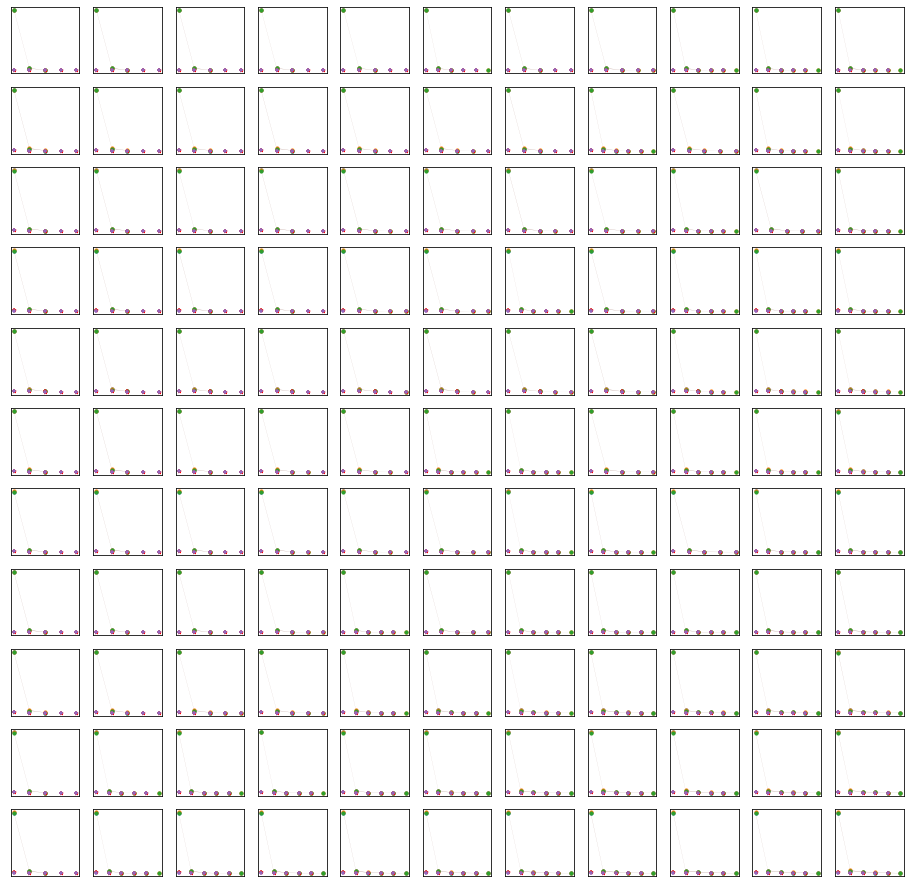

In [20]:
from itertools import zip_longest
import numpy.ma as ma # for masked arrays
plt.figure(figsize=(16,16))
index = 0

short_k = k*1000/np.sum(k)
lam_upper = []
lam_lower = []
lam_avgs = []
for gi_m in range(11):
    for gi_b in range(11):
        # avg, max, and min transit multiplicities to compare against data
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        lam_elt = lams[index]
        lam_elt_max = []
        lam_elt_min = []
        lam_elt_avg = []
        for temp_list in zip_longest(*lam_elt):
            elt = [0 if v is None else v for v in ma.masked_values(temp_list, 0)]
            lam_elt_max.append(max(elt))
            lam_elt_min.append(min(elt))
            lam_elt_avg.append(np.mean(elt))
        
        lam_upper.append(lam_elt_max)
        lam_lower.append(lam_elt_min)
        lam_avgs.append(lam_elt_avg)

        # plotting
        ax.scatter(pd.Series(lam_elt_avg).index, lam_elt_avg, s=10)
        ax.scatter(pd.Series(lam_elt_max).index, lam_elt_max, s=10)
        ax.scatter(pd.Series(lam_elt_min).index, lam_elt_min, s=10)
        ax.scatter(np.arange(5), nonzero_k, marker=(5, 1), color='r', s=10)
        ax.scatter(np.arange(5), nonzero_k+np.sqrt(nonzero_k), marker='+', s=10)
        ax.scatter(np.arange(5), nonzero_k-np.sqrt(nonzero_k), marker='+', s=10)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        #ax.set_ylim([0, 30])
        
        # draw envelope
        ax.fill_between(np.arange(len(lam_elt_min)), lam_elt_min, lam_elt_max, alpha=0.6)

        index += 1
plt.show()

In [86]:
df

,ms,bs,intact_fracs,logLs,lams,geometric_lams,geometric_logLs,fixed_logLs,mean_intact_fracs
0,-1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-861.3326564321698, -825.8876440117946, -825....","[[19178.0, 749.0, 42.0, 1e-12, 1e-12, 1e-12], ...","[[18627.0, 1223.0, 119.0, 1e-12, 1e-12, 1e-12]...","[-1261.4969915537633, -1250.2596228659804, -12...","[-650.6537307208537, -639.4163620330708, -679....",0.000000
1,-1.0,0.1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-799.328925833771, -777.0103471419387, -803.7...","[[19274.0, 656.0, 39.0, 1e-12, 1e-12, 1e-12], ...","[[18690.0, 1166.0, 113.0, 1e-12, 1e-12, 1e-12]...","[-1209.4231169020752, -1219.629124541648, -125...","[-598.5798560691655, -608.7858637087382, -642....",0.000000
2,-1.0,0.2,"[0.0, 0.0, 5.00776203114828e-05, 0.0, 5.007762...","[-805.1386708963076, -827.6047739947156, -832....","[[19255.0, 667.0, 47.0, 1e-12, 1e-12, 1e-12], ...","[[18638.0, 1207.0, 124.0, 1e-12, 1e-12, 1e-12]...","[-1251.0086758749592, -1220.2300831235755, -12...","[-640.1654150420494, -609.3868222906657, -607....",0.000010
3,-1.0,0.3,"[0.0001001552406229656, 0.0001502328609344484,...","[-808.4876059606244, -822.7657963210123, -816....","[[19243.0, 672.0, 54.0, 1e-12, 1e-12, 1e-12], ...","[[18684.0, 1157.0, 128.0, 1e-12, 1e-12, 1e-12]...","[-1211.2671824864144, -1244.2059895874816, -12...","[-600.4239216535047, -633.362728754572, -633.6...",0.000081
4,-1.0,0.4,"[0.0006510090640492763, 0.0004006209624918624,...","[-477.2874397003105, -788.1722031988063, -773....","[[19251.0, 671.0, 46.0, 1.0, 1e-12, 1e-12], [1...","[[18618.0, 1204.0, 146.0, 1.0, 1e-12, 1e-12], ...","[-932.8145577654657, -1209.7027296547874, -120...","[-673.5307648193615, -598.8594688218777, -597....",0.000415
...,...,...,...,...,...,...,...,...,...
116,0.0,0.6,"[0.5964244579097602, 0.6007812108768591, 0.596...","[-502.3173500269684, -558.7062623889922, -520....","[[18794.0, 701.0, 271.0, 123.0, 61.0, 15.0], [...","[[18127.0, 963.0, 376.0, 216.0, 188.0, 78.0], ...","[-1083.8886428193034, -1138.0793238613696, -11...","[-1083.8886428193034, -1138.0793238613696, -11...",0.600252
117,0.0,0.7,"[0.6946266713405779, 0.7012369172216937, 0.696...","[-620.6107843375355, -579.68334728838, -591.55...","[[18663.0, 725.0, 308.0, 176.0, 79.0, 16.0], [...","[[18004.0, 909.0, 418.0, 297.0, 226.0, 101.0],...","[-1227.8254671542775, -1200.6712207379887, -11...","[-1227.8254671542775, -1200.6712207379887, -11...",0.699880
118,0.0,0.8,"[0.8031448745555612, 0.8018428564274626, 0.799...","[-710.0745076737753, -699.3343845145812, -608....","[[18563.0, 726.0, 371.0, 183.0, 93.0, 27.0], [...","[[17908.0, 857.0, 483.0, 322.0, 248.0, 124.0],...","[-1324.9824728296974, -1348.7435038027836, -12...","[-1324.9824728296974, -1348.7435038027836, -12...",0.800016
119,0.0,0.9,"[0.9013971656066904, 0.8966397916770995, 0.902...","[-784.2720195137433, -766.9538395706194, -838....","[[18475.0, 780.0, 390.0, 197.0, 96.0, 27.0], [...","[[17736.0, 891.0, 510.0, 376.0, 272.0, 149.0],...","[-1491.6045251895155, -1456.4168055744135, -15...","[-1491.6045251895155, -1456.4168055744135, -15...",0.899931


In [46]:
df['mean_logLs'] = mean_logLs
df['mean_lams'] = lam_avgs

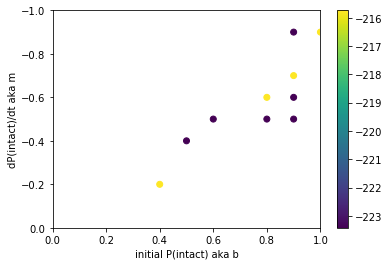

In [47]:
top_df = df.sort_values(['mean_logLs'], ascending=False).head(n=10)
plt.scatter(top_df.bs.to_list(), top_df.ms.to_list(), c=top_df.mean_logLs.to_list())
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m')
plt.xlim(0., 1.)
plt.ylim(-1., 0.)
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

In [ ]:
# Model and transit multiplicity plots for selected high-logL models
top_ms, top_bs = top_df.ms.to_list(), top_df.bs.to_list()
x = np.linspace(0, 10, 100)

fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(10,10))
fig.set_size_inches(15, 15)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
axes = axes.flatten()

for row in range(len(top_df.ms)):    
    logL = top_df.mean_logLs.to_list()[row]
    lam = pd.Series(top_df.mean_lams.to_list()[row])
    #lam.index += 1 # reset indices starting at 1 after reading back from list
    #print(lam)
    
    plt.subplot(5,2,row+1)
    plt.title('logL = %f' %logL)
    #plt.ylabel('Count [# of systems]')
    #plt.xlabel('Multiplicity [# of transiting planets]')
    plt.scatter(pd.Series(lam).index, lam)
    plt.scatter(np.arange(6), k, marker=(5, 1), color='r')
    #plt.scatter(np.arange(6), k+np.sqrt(k), marker='+')
    #plt.scatter(np.arange(6), k-np.sqrt(k), marker='+')
    print(lam)

#plt.title('Probability of staying intact as a function of time')
plt.show()

#### Troubleshooting: how to deal with zero-valued bins 

In [88]:
df.loc[(df.ms == 0) & (df.bs == 1)].lams

120    [[18311.0, 844.0, 442.0, 232.0, 106.0, 28.0], ...
Name: lams, dtype: object

In [89]:
df.loc[(df.ms == 0) & (df.bs == 0)].lams

110    [[19215.0, 712.0, 42.0, 1e-12, 1e-12, 1e-12], ...
Name: lams, dtype: object

In [87]:
df.loc[(df.ms == -1) & (df.bs == 0)].lams

0    [[19178.0, 749.0, 42.0, 1e-12, 1e-12, 1e-12], ...
Name: lams, dtype: object

In [90]:
df.loc[(df.ms == -1) & (df.bs == 1)].lams

10    [[19211.0, 688.0, 56.0, 8.0, 5.0, 1.0], [19234...
Name: lams, dtype: object

In [121]:
# multimodal population
df.loc[(df.ms == -1) & (df.bs == 0.6)].lams

6    [[19232.0, 695.0, 42.0, 1e-12, 1e-12, 1e-12], ...
Name: lams, dtype: object

### Redo but without zero bin

In [29]:
def better_loglike(lam, k):
    """
    Calculate Poisson log likelihood
    Changed 0 handling from simulate.py to reflect https://www.aanda.org/articles/aa/pdf/2009/16/aa8472-07.pdf
    """

    logL = []
    #print(lam)
    for i in range(len(lam)):
        if lam[i]==0:    
            term3 = -lgamma(k[i]+1)
            term2 = -lam[i]
            term1 = 0
            logL.append(term1+term2+term3)
        else:
            term3 = -lgamma(k[i]+1)
            term2 = -lam[i]
            term1 = k[i]*np.log(lam[i])
            logL.append(term1+term2+term3)

    return np.sum(logL)

In [30]:
### re-introduce nonzero-bin transit multiplicities
df_lams_nonzero = []
for x in df.lams:
    df_lams_nonzero.append([y[1:] for y in x])
df['lams_nonzero'] = df_lams_nonzero

In [31]:
fixed_logLs_nonzero = []
for x in df.lams_nonzero:
    temp_fixed_logLs_nonzero = []
    for y in x:
        #print(y, k[1:])
        temp_fixed_logLs_nonzero.append(better_loglike(y, k[1:].reset_index()[0]))
    fixed_logLs_nonzero.append(temp_fixed_logLs_nonzero)
df['logLs_nonzero'] = fixed_logLs_nonzero

In [32]:
df

,ms,bs,intact_fracs,logLs,lams,geometric_lams,geometric_logLs,cutoffs,lams_nonzero,logLs_nonzero
0,-0.1,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-197.462132380805, -553.1422661227691, -615.3...","[[19769.31, 199.69, 0.0, 0.0, 0.0, 0.0], [1877...","[[18970.55, 798.76, 199.69, 0.0, 0.0, 0.0], [1...","[-399.6190979703892, -718.8503232765049, -778....",0.1,"[[199.69, 0.0, 0.0, 0.0, 0.0], [998.45, 199.69...","[-191.25737710066724, -526.8694520999263, -597..."
1,-0.1,0.1,"[0.1, 0.09, 0.11, 0.07, 0.14, 0.16, 0.1, 0.1, ...","[-227.85877670653113, -330.4962881138846, -951...","[[19569.62, 399.38, 0.0, 0.0, 0.0, 0.0], [1936...","[[18571.17, 1198.1399999999999, 199.69, 0.0, 0...","[-718.8503232765049, -778.7908806318643, -1470...",0.1,"[[399.38, 0.0, 0.0, 0.0, 0.0], [599.0699999999...","[-221.8194650440402, -322.5759786656482, -914...."
2,-0.1,0.2,"[0.24, 0.22, 0.21, 0.25, 0.15, 0.21, 0.26, 0.2...","[-227.85877670653113, -951.3726317654742, -113...","[[19569.62, 399.38, 0.0, 0.0, 0.0, 0.0], [1857...","[[19170.239999999998, 798.76, 0.0, 0.0, 0.0, 0...","[-463.9617160452466, -1219.7206220577818, -113...",0.1,"[[399.38, 0.0, 0.0, 0.0, 0.0], [1397.83, 0.0, ...","[-221.8194650440402, -914.5953007311706, -1081..."
3,-0.1,0.3,"[0.33, 0.32, 0.35, 0.35, 0.31, 0.24, 0.33, 0.3...","[-330.4962881138846, -745.9048495195141, -126....","[[19369.93, 599.0699999999999, 0.0, 0.0, 0.0, ...","[[18970.55, 998.45, 0.0, 0.0, 0.0, 0.0], [1817...","[-615.3071458165424, -1079.360651054333, -434....",0.1,"[[599.0699999999999, 0.0, 0.0, 0.0, 0.0], [798...","[-322.5759786656482, -709.1275184852104, -120...."
4,-0.1,0.4,"[0.41, 0.44, 0.34, 0.43, 0.35, 0.38, 0.43, 0.4...","[-699.7755891655663, -895.9667512640724, -759....","[[18571.17, 998.45, 199.69, 199.69, 0.0, 0.0],...","[[18371.48, 798.76, 199.69, 199.69, 399.38, 0....","[-918.7702431254362, -1138.5978570001753, -124...",0.1,"[[998.45, 199.69, 199.69, 0.0, 0.0], [1198.139...","[-662.9982581312627, -846.412486033644, -733.4..."
...,...,...,...,...,...,...,...,...,...,...
116,-10.0,0.6,"[0.65, 0.52, 0.65, 0.63, 0.7, 0.58, 0.54, 0.56...","[-286.04848286964096, -903.9247571949718, -112...","[[19369.93, 199.69, 199.69, 0.0, 199.69, 0.0],...","[[18171.79, 798.76, 599.0699999999999, 199.69,...","[-1120.1525801653686, -1530.8517805832175, -22...",0.1,"[[199.69, 199.69, 0.0, 199.69, 0.0], [998.45, ...","[-278.1281734214046, -854.3704919645434, -1064..."
117,-10.0,0.7,"[0.68, 0.76, 0.73, 0.77, 0.68, 0.67, 0.71, 0.6...","[-882.9631882325278, -946.9809308855425, -953....","[[18571.17, 399.38, 599.0699999999999, 0.0, 39...","[[17572.72, 399.38, 998.45, 199.69, 199.69, 59...","[-1878.5771104442883, -1841.8484126220258, -18...",0.1,"[[399.38, 599.0699999999999, 0.0, 399.38, 0.0]...","[-846.1858571982242, -897.4266656551141, -903...."
118,-10.0,0.8,"[0.72, 0.76, 0.81, 0.79, 0.78, 0.82, 0.76, 0.8...","[-434.46301744006655, -1066.1193854514759, -69...","[[18970.55, 599.0699999999999, 399.38, 0.0, 0....","[[18571.17, 599.0699999999999, 599.06999999999...","[-789.5748792986155, -1247.9313098178882, -960...",0.1,"[[599.0699999999999, 399.38, 0.0, 0.0, 0.0], [...","[-416.4703980902707, -1001.466097051908, -662...."
119,-10.0,0.9,"[0.87, 0.92, 0.85, 0.88, 0.89, 0.95, 0.91, 0.8...","[-621.754491599597, -1243.6782905260013, -320....","[[18770.86, 599.0699999999999, 599.06999999999...","[[17173.34, 1397.83, 599.0699999999999, 599.06...","[-2081.057448750574, -2322.6917432455016, -665...",0.1,"[[599.0699999999999, 599.0699999999999, 0.0, 0...","[-595.4816775767542, -1161.5525715514639, -308..."


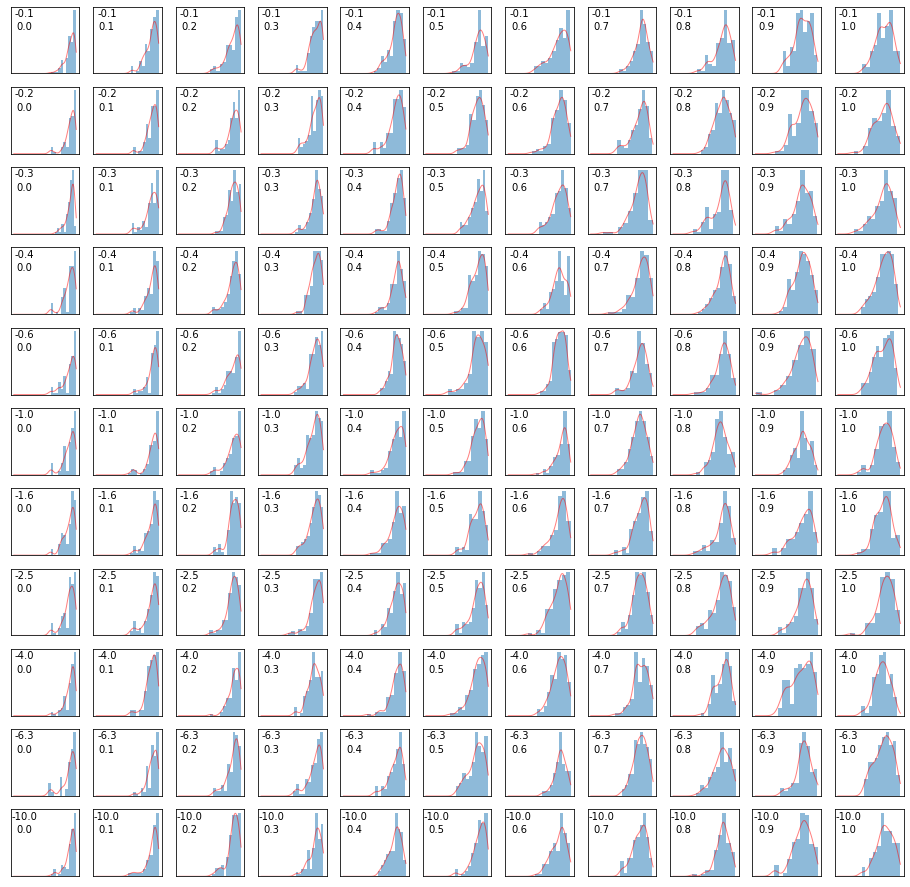

In [40]:
def kde_func(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    kde = gaussian_kde(x) # constant bandwidth so imbalance in sample size doesn't drive distribution
    return kde.evaluate(x_grid)

def prior_grid(cube, ndim, nparams, gi_m, gi_b):
    """
    Each model run will use an evenly spaced (m,b) tuple on a discrete 11x11 grid
    Does that ruin the point of multinest? Is it valid without random sampling? 
    Maybe so, but pymultinest keeps getting stuck, so I need to get a better sense of the logL surface.
    gi_m: grid index on m axis
    gi_b: grid index on b axis
    """
    cube[0] = np.linspace(-1,0,11)[gi_m]
    cube[1] = np.linspace(0,1,11)[gi_b]
    return cube

def generate_rand_from_pdf(pdf, x_grid, n):
    cdf = np.cumsum(pdf) # create cdf
    cdf = cdf / cdf[-1] # normalize cdf
    values = np.random.rand(n) 
    value_bins = np.searchsorted(cdf, values) # return positions in cdf vector where random values should go
    random_from_cdf = x_grid[value_bins] # select x_d positions based on these random positions
    return random_from_cdf

def kde(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    #kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=0)) # ddof=1 means std divisor is N-1 instead of N
    #kde = gaussian_kde(x, bw_method=np.power(len(x), -0.2)) # ddof=1 means std divisor is N-1 instead of N
    kde = gaussian_kde(x, bw_method=0.15) # constant bandwidth so imbalance in sample size doesn't drive distribution
    #print(bandwidth/x.std(ddof=1)) # this is bw used in S/O
    #print(np.power(len(x), -0.2)) # the bw if I use Scott's factor as the bw to multiply with covariance matrix
    return kde.evaluate(x_grid)

plt.figure(figsize=(16,16))
index = 0
ndim = 2
nbins = 10
nparams = 2
draws = 50
logLs = df.logLs_nonzero
lams = df.lams_nonzero
lower = min([min(i) for i in logLs])
upper = max([max(i) for i in logLs])
bs = df.bs
ms = df.ms
mean_logLs = []
mean_logLs2 = []
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        ax.text(0.2, 0.9, round(ms[index], 1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, bs[index], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        hist, bins = np.histogram(logLs[index], bins=20)
        
        x_grid = np.linspace(lower, upper, 100)
        kdepdf = kde_func(np.array(logLs[index]), x_grid, bandwidth=0.2) # generate KDE model
        mean_logLs.append(x_grid[np.argmax(kdepdf)])
        mean_logLs2.append(np.mean(logLs[index]))
        #random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
        #print(kdepdf)
        
        bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
        random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from histogram
        
        #plt.hist(logLs[index], bins=np.linspace(lower, upper, 20))
        ax.hist(logLs[index], nbins, density=True, alpha=0.5) # plot histogram of normalized data
        ax.plot(x_grid, kdepdf, color='r', alpha=0.5, lw=1) # plot KDE over normalized histogram
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
plt.show()

In [41]:
df

,ms,bs,intact_fracs,logLs,lams,geometric_lams,geometric_logLs,cutoffs,lams_nonzero,logLs_nonzero,mean_intact_fracs
0,-0.1,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-197.462132380805, -553.1422661227691, -615.3...","[[19769.31, 199.69, 0.0, 0.0, 0.0, 0.0], [1877...","[[18970.55, 798.76, 199.69, 0.0, 0.0, 0.0], [1...","[-399.6190979703892, -718.8503232765049, -778....",0.1,"[[199.69, 0.0, 0.0, 0.0, 0.0], [998.45, 199.69...","[-191.25737710066724, -526.8694520999263, -597...",0.0000
1,-0.1,0.1,"[0.1, 0.09, 0.11, 0.07, 0.14, 0.16, 0.1, 0.1, ...","[-227.85877670653113, -330.4962881138846, -951...","[[19569.62, 399.38, 0.0, 0.0, 0.0, 0.0], [1936...","[[18571.17, 1198.1399999999999, 199.69, 0.0, 0...","[-718.8503232765049, -778.7908806318643, -1470...",0.1,"[[399.38, 0.0, 0.0, 0.0, 0.0], [599.0699999999...","[-221.8194650440402, -322.5759786656482, -914....",0.1040
2,-0.1,0.2,"[0.24, 0.22, 0.21, 0.25, 0.15, 0.21, 0.26, 0.2...","[-227.85877670653113, -951.3726317654742, -113...","[[19569.62, 399.38, 0.0, 0.0, 0.0, 0.0], [1857...","[[19170.239999999998, 798.76, 0.0, 0.0, 0.0, 0...","[-463.9617160452466, -1219.7206220577818, -113...",0.1,"[[399.38, 0.0, 0.0, 0.0, 0.0], [1397.83, 0.0, ...","[-221.8194650440402, -914.5953007311706, -1081...",0.2003
3,-0.1,0.3,"[0.33, 0.32, 0.35, 0.35, 0.31, 0.24, 0.33, 0.3...","[-330.4962881138846, -745.9048495195141, -126....","[[19369.93, 599.0699999999999, 0.0, 0.0, 0.0, ...","[[18970.55, 998.45, 0.0, 0.0, 0.0, 0.0], [1817...","[-615.3071458165424, -1079.360651054333, -434....",0.1,"[[599.0699999999999, 0.0, 0.0, 0.0, 0.0], [798...","[-322.5759786656482, -709.1275184852104, -120....",0.2956
4,-0.1,0.4,"[0.41, 0.44, 0.34, 0.43, 0.35, 0.38, 0.43, 0.4...","[-699.7755891655663, -895.9667512640724, -759....","[[18571.17, 998.45, 199.69, 199.69, 0.0, 0.0],...","[[18371.48, 798.76, 199.69, 199.69, 399.38, 0....","[-918.7702431254362, -1138.5978570001753, -124...",0.1,"[[998.45, 199.69, 199.69, 0.0, 0.0], [1198.139...","[-662.9982581312627, -846.412486033644, -733.4...",0.3974
...,...,...,...,...,...,...,...,...,...,...,...
116,-10.0,0.6,"[0.65, 0.52, 0.65, 0.63, 0.7, 0.58, 0.54, 0.56...","[-286.04848286964096, -903.9247571949718, -112...","[[19369.93, 199.69, 199.69, 0.0, 199.69, 0.0],...","[[18171.79, 798.76, 599.0699999999999, 199.69,...","[-1120.1525801653686, -1530.8517805832175, -22...",0.1,"[[199.69, 199.69, 0.0, 199.69, 0.0], [998.45, ...","[-278.1281734214046, -854.3704919645434, -1064...",0.6050
117,-10.0,0.7,"[0.68, 0.76, 0.73, 0.77, 0.68, 0.67, 0.71, 0.6...","[-882.9631882325278, -946.9809308855425, -953....","[[18571.17, 399.38, 599.0699999999999, 0.0, 39...","[[17572.72, 399.38, 998.45, 199.69, 199.69, 59...","[-1878.5771104442883, -1841.8484126220258, -18...",0.1,"[[399.38, 599.0699999999999, 0.0, 399.38, 0.0]...","[-846.1858571982242, -897.4266656551141, -903....",0.7060
118,-10.0,0.8,"[0.72, 0.76, 0.81, 0.79, 0.78, 0.82, 0.76, 0.8...","[-434.46301744006655, -1066.1193854514759, -69...","[[18970.55, 599.0699999999999, 399.38, 0.0, 0....","[[18571.17, 599.0699999999999, 599.06999999999...","[-789.5748792986155, -1247.9313098178882, -960...",0.1,"[[599.0699999999999, 399.38, 0.0, 0.0, 0.0], [...","[-416.4703980902707, -1001.466097051908, -662....",0.8004
119,-10.0,0.9,"[0.87, 0.92, 0.85, 0.88, 0.89, 0.95, 0.91, 0.8...","[-621.754491599597, -1243.6782905260013, -320....","[[18770.86, 599.0699999999999, 599.06999999999...","[[17173.34, 1397.83, 599.0699999999999, 599.06...","[-2081.057448750574, -2322.6917432455016, -665...",0.1,"[[599.0699999999999, 599.0699999999999, 0.0, 0...","[-595.4816775767542, -1161.5525715514639, -308...",0.9026


In [33]:
10**ms

0      7.943282e-01
1      7.943282e-01
2      7.943282e-01
3      7.943282e-01
4      7.943282e-01
           ...     
116    1.000000e-10
117    1.000000e-10
118    1.000000e-10
119    1.000000e-10
120    1.000000e-10
Name: ms, Length: 121, dtype: float64

In [79]:
np.log10(np.logspace(8,10,11))

array([ 8. ,  8.2,  8.4,  8.6,  8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. ])

In [72]:
10**(ms*1e9)

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
116    0.0
117    0.0
118    0.0
119    0.0
120    0.0
Name: ms, Length: 121, dtype: float64

In [73]:
-1e-9*np.logspace(8,10,11)

array([ -0.1       ,  -0.15848932,  -0.25118864,  -0.39810717,
        -0.63095734,  -1.        ,  -1.58489319,  -2.51188643,
        -3.98107171,  -6.30957344, -10.        ])

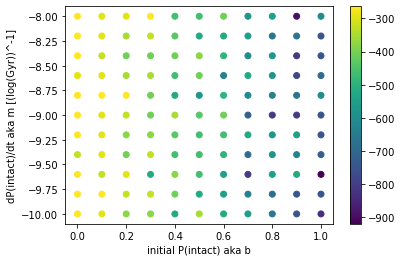

In [42]:
plt.scatter(bs, [-1*m for m in ms_corrected_for_plotting], c=mean_logLs) # mean_logLs2 for mean instead of peak location of KDE
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m [(log(Gyr))^-1]')
#plt.gca().invert_yaxis()
#plt.yscale('symlog', linthreshy=10)
#plt.yscale('log')
plt.colorbar()
plt.show()

Alternative way of displaying

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  """


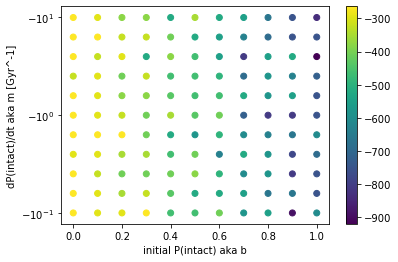

In [43]:
plt.scatter(bs, df.ms, c=mean_logLs) # mean_logLs2 for mean instead of peak location of KDE
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m [Gyr^-1]')
#plt.gca().invert_yaxis()
plt.yscale('symlog', linthreshy=0.1)
#plt.yscale('symlog', base=10)
#plt.yscale('log')
plt.colorbar()
#plt.tight_layout()
plt.ylim(-0.09, -13) 
plt.show()

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  if __name__ == '__main__':


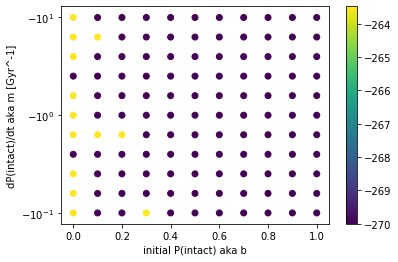

In [44]:
# to better show color differences for logL comparison
mean_logLs_new = np.array(mean_logLs)
mean_logLs_new[mean_logLs_new < -270] = -270

plt.scatter(bs, df.ms, c=mean_logLs_new) # mean_logLs2 for mean instead of peak location of KDE
plt.xlabel('initial P(intact) aka b')
plt.ylabel('dP(intact)/dt aka m [Gyr^-1]')
#plt.gca().invert_yaxis()
plt.yscale('symlog', linthreshy=0.1)
#plt.yscale('symlog', base=10)
#plt.yscale('log')
plt.colorbar()
#plt.tight_layout()
plt.ylim(-0.09, -13) 
plt.show()

In [38]:
df.loc[:, "mean_intact_fracs"] = df.intact_fracs.apply(lambda x: np.mean(x))

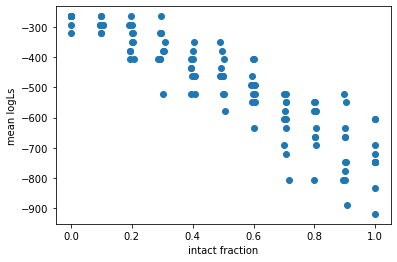

In [39]:
plt.scatter(df.mean_intact_fracs, mean_logLs)
plt.ylabel('mean logLs')
plt.xlabel('intact fraction')
plt.show()

/Users/chris/anaconda2/lib/python3.6/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/chris/anaconda2/lib/python3.6/site-packages/numpy/ma/core.py:2832: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/Users/chris/anaconda2/lib/python3.6/site-packages/numpy/ma/core.py:2363: UserWarning: Warning: converting a masked element to nan.
  a = np.array(a, copy=copy, subok=True)


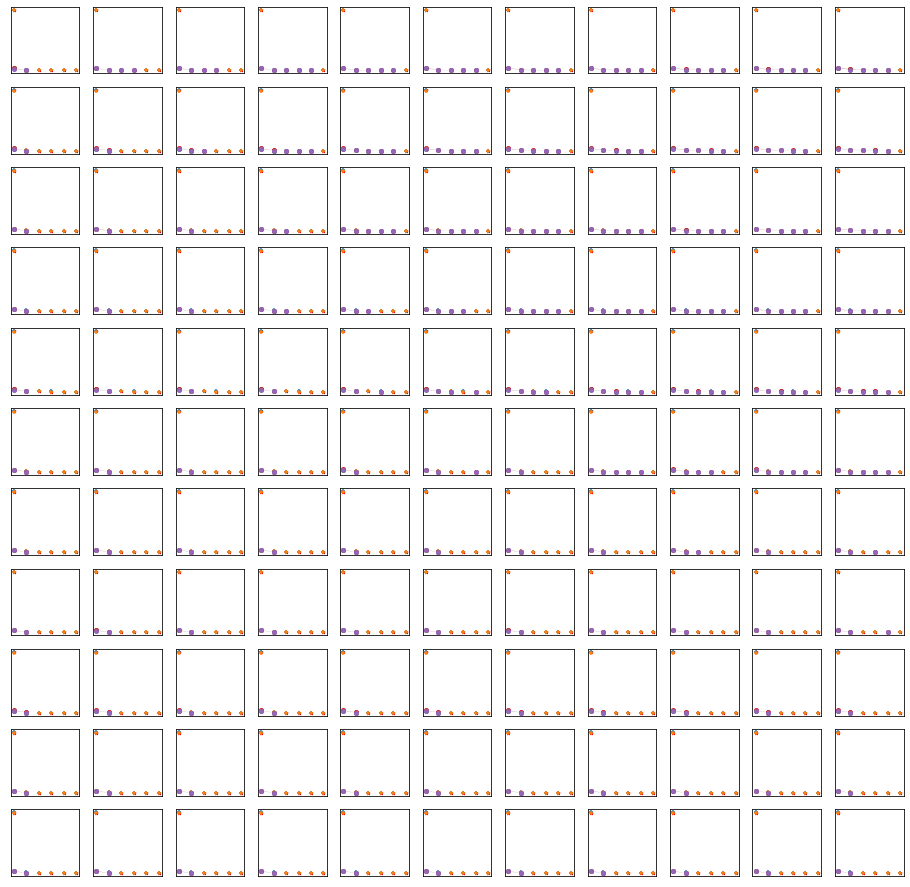

In [119]:
from itertools import zip_longest
import numpy.ma as ma # for masked arrays

plt.figure(figsize=(16,16))
index = 0

#short_k = k*1000/np.sum(k)
lam_upper = []
lam_lower = []
lam_avgs = []
for gi_m in range(11):
    for gi_b in range(11):
        # avg, max, and min transit multiplicities to compare against data
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        lam_elt = lams[index]
        lam_elt_max = []
        lam_elt_min = []
        lam_elt_avg = []
        for temp_list in zip_longest(*lam_elt):
            elt = [0 if v is None else v for v in ma.masked_values(temp_list, 0)]
            lam_elt_max.append(max(elt))
            lam_elt_min.append(min(elt))
            lam_elt_avg.append(np.mean(elt))
        
        lam_upper.append(lam_elt_max)
        lam_lower.append(lam_elt_min)
        lam_avgs.append(lam_elt_avg)

        # plotting
        ax.scatter(np.arange(6), k, marker=(5, 1), color='r', s=10)
        ax.scatter(np.arange(6), k+np.sqrt(k), marker='+', s=10)
        ax.scatter(np.arange(6), k-np.sqrt(k), marker='+', s=10)
        ax.scatter(pd.Series(lam_elt_avg).index, lam_elt_avg, s=16)
        ax.scatter(pd.Series(lam_elt_max).index, lam_elt_max, s=16)
        ax.scatter(pd.Series(lam_elt_min).index, lam_elt_min, s=16)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        #ax.set_ylim([0, 30])
        
        # draw envelope
        ax.fill_between(np.arange(len(lam_elt_min)), lam_elt_min, lam_elt_max, alpha=0.6)

        index += 1
plt.show()

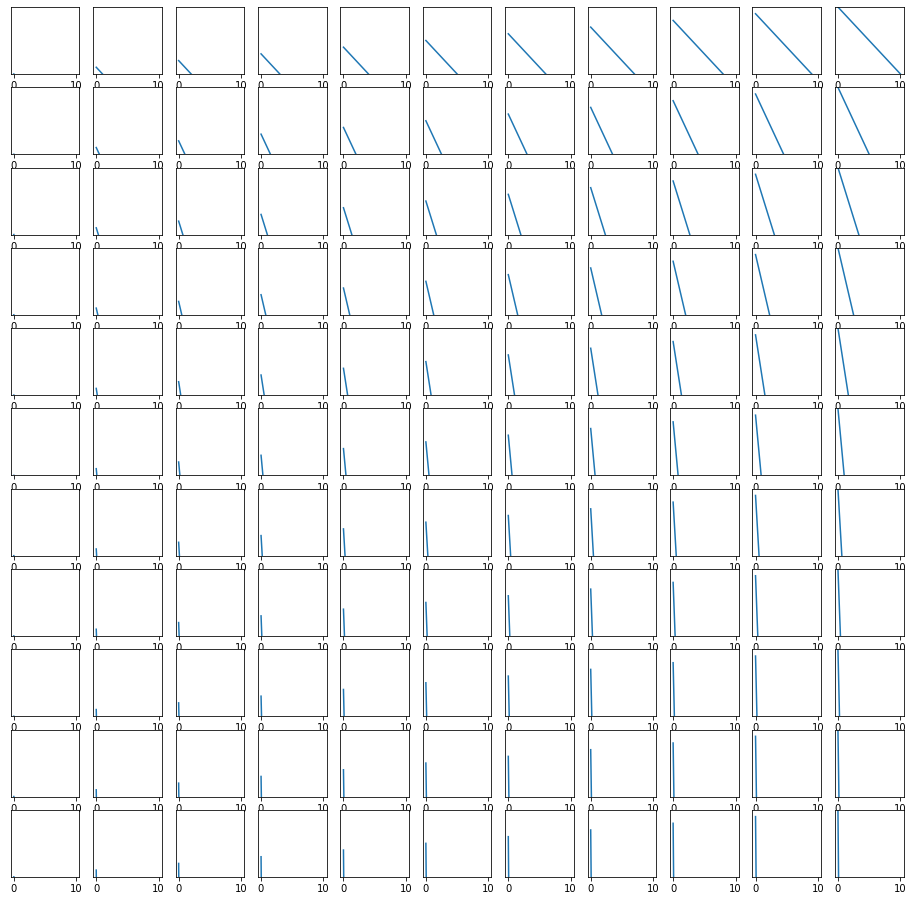

In [151]:
plt.figure(figsize=(16,16))
index = 0
x = np.linspace(0, 10, 100)

def prob_intact(x, m, b, cutoff):
    prob = m*x + b
    #prob = [0.05 if i < 0.05 else i for i in prob] # nah, keep it at zero if it's zero
    return prob

for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        #cube = [random.uniform(0,1), random.uniform(0,1)]
        #cube = prior_grid(cube, ndim, nparams, gi_m, gi_b)
        cutoff = 0 # placeholder
        #print(round(df.ms[index], 1))
        
        print(round(df.ms[index], 1), df.bs[index])
        y = prob_intact(x, round(df.ms[index], 1), df.bs[index], cutoff)
        #y = prob_intact(x, np.linspace(-1,0,11)[gi_m], np.linspace(0,1,11)[gi_b])
        ax.plot(x, y)
        ax.set_ylim([0, 1])
        #ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        #ax.set_xscale('symlog')
        
        index += 1
plt.show()

In [165]:
round(df.ms[120], 1), df.bs[120]

(-10.0, 1.0)

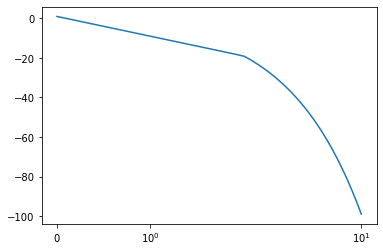

In [160]:
plt.plot(x, y)
plt.xscale('symlog', base=10)
plt.show()

Uh oh, is it the slope itself that's supposed to be drawn from logspace, or should the probability also follow a log(x) shape? That is, I thought I was working in log(time) space, but it looks like I'm not...

Okay, so what happened was that I used -0.1 through -10.0 as my slopes (eg. -1e-9 * 1e8 = -0.1), which makes sense in its own right, but might not be what I want. On the other hand, -0.1 P(intact) per Gyr (using what I did) as the shallowest is the same as -1 P(intact) per 10 Gyrs (using Sarah's plot), as long as I can treat the probability as decreasing linearly with time (I don't think I can...this is the main question). Similarly, Sarah's steepest slope (-1 P(intact) per 0.1 Gyr) is the same as my steepest slope (-10 P(intact) per 1 Gyr). Or, rather than immediately descend from t=0 Gyr, I start descending in P(intact) at 10^8 yrs.

In [268]:
print(np.min(berger_kepler.iso_age)) # well after lower limit of 0.1 Gyr
print(np.max(berger_kepler.iso_age)) # well before upper limit of 10 Gyr
print(len(berger_kepler.loc[berger_kepler.iso_age < 0.3])) # using -2 as max abs value of slope (<-0.21 for -3 slope)

0.14
8.49
31


In [276]:
# pick slope values
print(np.linspace(-2, 0, 11))
#print(np.logspace(0, 0.6, 10))

[-2.  -1.8 -1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0. ]


[1.00000000e+08 1.04761575e+08 1.09749877e+08 1.14975700e+08
 1.20450354e+08 1.26185688e+08 1.32194115e+08 1.38488637e+08
 1.45082878e+08 1.51991108e+08 1.59228279e+08 1.66810054e+08
 1.74752840e+08 1.83073828e+08 1.91791026e+08 2.00923300e+08
 2.10490414e+08 2.20513074e+08 2.31012970e+08 2.42012826e+08
 2.53536449e+08 2.65608778e+08 2.78255940e+08 2.91505306e+08
 3.05385551e+08 3.19926714e+08 3.35160265e+08 3.51119173e+08
 3.67837977e+08 3.85352859e+08 4.03701726e+08 4.22924287e+08
 4.43062146e+08 4.64158883e+08 4.86260158e+08 5.09413801e+08
 5.33669923e+08 5.59081018e+08 5.85702082e+08 6.13590727e+08
 6.42807312e+08 6.73415066e+08 7.05480231e+08 7.39072203e+08
 7.74263683e+08 8.11130831e+08 8.49753436e+08 8.90215085e+08
 9.32603347e+08 9.77009957e+08 1.02353102e+09 1.07226722e+09
 1.12332403e+09 1.17681195e+09 1.23284674e+09 1.29154967e+09
 1.35304777e+09 1.41747416e+09 1.48496826e+09 1.55567614e+09
 1.62975083e+09 1.70735265e+09 1.78864953e+09 1.87381742e+09
 1.96304065e+09 2.056512

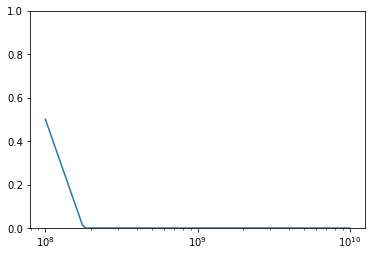

In [68]:
def plot_prob(x, m, b):
    #return x*np.log10(m) + b
    #return -np.log10(x*m) + b
    #return -np.log10(x*m) + b # y=mx+b
    #return -np.log10(m * (x-1e8)) + b # linear equation given slope and one point, but with slope and x axis logged
    y = []
    for x_elt in x:
        if x_elt <= 1e8:
            y.append(b)
        elif x_elt > 1e8:
            #print(np.log10(x_elt), m, b)
            y_elt = b + m*(np.log10(x_elt)-8)
            if y_elt < 0: # handle negative probabilities
                y_elt = 0
            elif y_elt > 1:
                y_elt = 1
            y.append(y_elt) # from Ballard et al in prep
            
    return y

def plot_prob2(x, m, b):
    y = []
    for x_elt in x:
        if x_elt <= 0.1:
            y.append(b)
        elif x_elt > 0.1:
            #print(np.log10(x_elt), m, b)
            y_elt = b + m*(x_elt-0.1)
            if y_elt < 0: # handle negative probabilities
                y_elt = 0
            elif y_elt > 1:
                y_elt = 1
            y.append(y_elt) # from Ballard et al in prep
            
    return y

x = np.logspace(8, 10, 100)
#x = np.linspace(0.1, 10, 100)
#y = plot_prob(x, -0.1, 1)
y = plot_prob(x, -2, 0.5)
print(x)
#print(np.log10(x))
print(y)
plt.plot(x, y)
plt.xscale('log')
plt.ylim(0, 1)
plt.show()

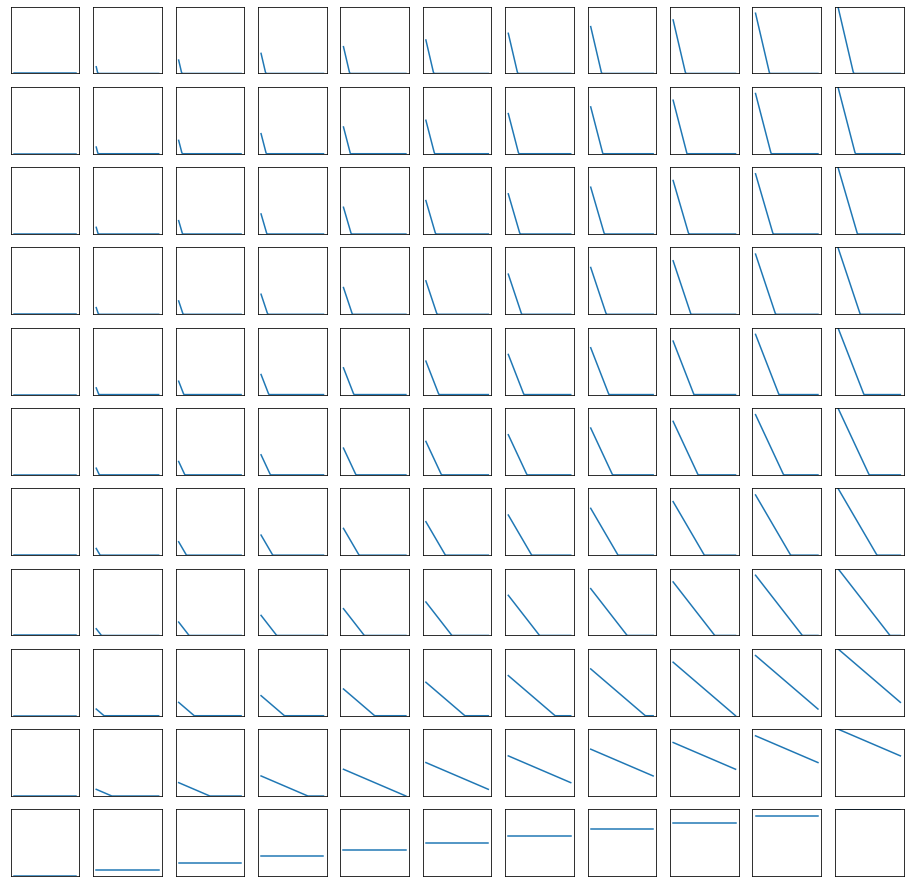

In [285]:
plt.figure(figsize=(16,16))
index = 0
ms = np.linspace(-2, 0, 11)
for i, gi_m in enumerate(ms):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (i,gi_b))
        #cube = [random.uniform(0,1), random.uniform(0,1)]
        #cube = prior_grid(cube, ndim, nparams, gi_m, gi_b)
        cutoff = 0 # placeholder
        
        #print(round(gi_m, 1), df.bs[index])
        y = plot_prob(x, round(gi_m, 1), df.bs[index])
        #y = prob_intact(x, round(df.ms[index], 1), df.bs[index], cutoff)
        #y = prob_intact(x, np.linspace(-1,0,11)[gi_m], np.linspace(0,1,11)[gi_b])
        ax.plot(x, y)
        ax.set_ylim([0, 1])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_xscale('log')
        
        index += 1
plt.show()

In [63]:
def compute_prob(x, m, b, cutoff): # adapted from Ballard et al in prep
    #y = []
    cutoff = 0 # placeholder
    if x <= 0.1: # assume any decay starts at 1e8 yrs
        y = b
    elif x > 0.1:
        #print(np.log10(x), m, b)
        y = b + m*(x-0.1) # offset by 1e8 yrs to get max(t=index) = 1
        print(y)
        if y < 0: # handle negative probabilities
            y = 0
        elif y > 1: # handle cases where 1-y < 0
            y = 1
            
    return y

def compute_prob2(x, m, b):
    x = x*1e9
    if x <= 1e8:
        y = b
    elif x > 1e8:
        #print(np.log10(x_elt), m, b)
        y = b + m*(np.log10(x)-8)
        print(y)
        if y < 0: # handle negative probabilities
            y = 0
        elif y > 1:
            y = 1
            
    return y

print(compute_prob(1, -0.2, 1, 0))  
print(compute_prob2(1, -0.2, 1))


0.82
0.82
0.8
0.8


In [49]:
plt.plot(np.linspace(0, 10, 100), compute_prob(np.linspace(0, 10, 100), -2, 1, 0))
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

This is it (for now), Chief.

In [167]:
def prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c):
    """
    Each model run will use an evenly spaced (m,b) tuple on a discrete 11x11x11 3D grid
    Fixed from simulate.py by adding third param (cutoff) and taking m and cutoff into logspace
    Since m and cutoff don't have natural intervals anymore, I'm going to go from 10 to 9 intervals.
    This saves me ~20% runtime (from 11^3 to 1100 runs).
    Okay fine guess not.

    gi_m: grid index on m axis
    gi_b: grid index on b axis
    gi_c: grid index for cutoff time axis
    """
    cube[0] = -1e-9*np.logspace(8,10,11)[gi_m] # convert from year to Gyr
    cube[1] = np.linspace(0,1,11)[gi_b]
    #cube[2] = np.logspace(1e8,1e10,11)
    cube[2] = 1e-9*np.logspace(8,10,11)[gi_c] # convert from year to Gyr 
    return cube

def loglike_direct_draw_better(cube, ndim, nparams, k):
    """
    Run model per hyperparam draw and calculate Poisson log likelihood
    2nd iteration of bridge function between model_direct_draw() and better_logllike()
    Includes geometric transit multiplicity and 0 handling.
    Commented out the zero handling because it's wrong.

    Params: 
    - cube: hyperparam cube of slope and intercept
    - ndim: number of dimensions
    - nparams: number of parameters
    - k: from Berger et al 2020
    Returns: Poisson log-likelihood
    """

    # retrieve prior cube and feed prior-normalized hypercube into model to generate transit multiplicities
    lam, geom_lam, transits, intact_fractions, prob = model_direct_draw(cube)
    #lam = [1e-12 if x==0.0 else x for x in lam] # avoid -infs in logL by turning 0 lams to 1e-12
    #geom_lam = [1e-12 if x==0.0 else x for x in geom_lam] # ditto
    logL = better_loglike(lam, k)
    geom_logL = better_loglike(geom_lam, k)
    
    return logL, lam, geom_lam, geom_logL, transits, intact_fractions, prob

def model_direct_draw(cube):
    """
    Take prior and draw systems out of Kepler data 
    Params: n-dim hypercube prior
    Returns: lambdas and simulated transit DataFrame
    """
    # retrieve prior
    #print(cube)
    m, b, cutoff = cube[0], cube[1], cube[2]
    
    kepids = []
    midplanes = []
    midplanes_degrees = []
    inclinations = []
    inclinations_degrees = []
    planets_per_case2 = [] # maybe better to recreate it here b/c I can then generalize it for Case 2?
    planets_a_case2 = []
    star_radius = []
    star_mass = []
    impact_parameters = []
    transit_status1 = []
    transit_status2 = []
    transit_statuses = []
    transit_multiplicities = []
    geometric_transit_multiplicity = []
    tdurs = []
    jmags = []
    sns = []
    prob_detections = []
    xi = []
    xi_old = []
    xi_young = []
    intacts = 0
    
    # draw ~20000 systems
    num_samples = len(berger_kepler)
    num_samples = 3
    for i in range(len(berger_kepler[0:num_samples])):
    #for i in range(10):
        ### star ###
        kepids.append(berger_kepler.kepid[i])
        r_star = berger_kepler.iso_rad[i] # in solar radii
        m_star = berger_kepler.iso_mass[i] # in solar masses
        age_star = berger_kepler.iso_age[i]
        mu = list(np.random.uniform(-np.pi/2,np.pi/2,1)) # create midplane for star 
        midplanes.append(mu)
        midplanes_degrees.append([mu_elt*180/np.pi for mu_elt in mu])
        cdpp = berger_kepler.rrmscdpp06p0[i] # don't convert from ppm to parts per unit

        ### planet ###
        r_planet = 2. # use two Earth radii; will make negligible difference
        
        """
        # calculate probability given age using piecewise model
        #print("m, b, cutoff: ", m, b, cutoff)
        #print("age star: ", age_star)
        if age_star < cutoff: # if decay cutoff hasn't occurred yet, follow decay model
            prob = m * age_star + b
        else: # if decay cutoff has occurred, use P(intact) at time when cutoff occurred
            prob = m * cutoff + b 
        """

        # not including piecewise/cutoff model
        prob = m * age_star + b

        if prob < 0.: # don't allow negative probabilities
            prob = 0.
        intact_flag = np.random.choice(['intact', 'disrupted'], p=[prob, 1-prob])
        if intact_flag == 'intact':
            intacts += 1
            # young system has 5 or 6 planets
            num_planets = random.choice([5, 6]) 
            sigma = np.pi/90 # 2 degrees, per Fig 6 in Fabrycky 2012
            
            # simulate transit-related characteristics for 5 or 6 planets
            sim_transits_new(r_star, m_star, num_planets, mu, sigma, r_planet, age_star, 
                             planets_per_case2 = planets_per_case2, planets_a_case2 = planets_a_case2, 
                             inclinations = inclinations, inclinations_degrees = inclinations_degrees,
                             impact_parameters = impact_parameters, transit_statuses = transit_statuses, 
                             transit_status1 = transit_status1, transit_status2 = transit_status2, 
                             transit_multiplicities = transit_multiplicities, tdurs = tdurs,
                             cdpp = cdpp, sns = sns, prob_detections = prob_detections, 
                             geometric_transit_multiplicity = geometric_transit_multiplicity)

        elif intact_flag == 'disrupted':
            # old system has 1 or 2 planets
            num_planets = random.choice([1, 2]) 
            sigma = np.pi/22.5 # 8 degree disk plane inclination scatter
            
            # simulate transit-related characteristics for 1 or 2 planets
            sim_transits_new(r_star, m_star, num_planets, mu, sigma, r_planet, age_star, 
                             planets_per_case2 = planets_per_case2, planets_a_case2 = planets_a_case2, 
                             inclinations = inclinations, inclinations_degrees = inclinations_degrees, 
                             impact_parameters = impact_parameters, transit_statuses = transit_statuses, 
                             transit_status1 = transit_status1, transit_status2 = transit_status2,
                             transit_multiplicities = transit_multiplicities, tdurs = tdurs,
                             cdpp = cdpp, sns = sns, prob_detections = prob_detections,
                             geometric_transit_multiplicity = geometric_transit_multiplicity)

    midplanes = np.concatenate(midplanes, axis=0) # turn list of lists of one into regular list
    intact_fractions = intacts/num_samples
    #print(intacts, num_samples, intact_fractions)
    
    """
    transits_dict = {'star_ages': berger_kepler.iso_age, 'planet_periods': planets_per_case2, 
    'semi_major_axes': planets_a_case2, 'midplane': midplanes, 'midplane_degrees': midplanes_degrees,
                     'planet_inclinations': inclinations, 'planet_inclinations_degrees': inclinations_degrees,
                     'impact_parameters': impact_parameters, 'transit_status': transit_statuses, 
                     'transit_multiplicity': transit_multiplicities, 'kepid': kepids,
                     'y_intercept': b, 'slope': m, 'transit_duration': tdurs, 
                     '6hr_cdpp': berger_kepler.rrmscdpp06p0, 'signal_noise': sns,
                     'prob_detections': prob_detections}
    """
    transits_dict = {'star_ages': berger_kepler.iso_age[0:num_samples], 'planet_periods': planets_per_case2[0:num_samples], 
    'semi_major_axes': planets_a_case2[0:num_samples], 'midplane': midplanes[0:num_samples], 'midplane_degrees': midplanes_degrees[0:num_samples],
                     'planet_inclinations': inclinations[0:num_samples], 'planet_inclinations_degrees': inclinations_degrees[0:num_samples],
                     'impact_parameters': impact_parameters[0:num_samples], 'transit_status': transit_statuses[0:num_samples], 
                     'geometric_transit': transit_status1[0:num_samples], 'geometric_transit_multiplicity': geometric_transit_multiplicity[0:num_samples],
                     'transit_multiplicity': transit_multiplicities[0:num_samples], 'kepid': kepids[0:num_samples],
                     'y_intercept': b, 'slope': m, 'transit_duration': tdurs[0:num_samples], 
                     '6hr_cdpp': berger_kepler.rrmscdpp06p0[0:num_samples], 'signal_noise': sns[0:num_samples],
                     'prob_detections': prob_detections[0:num_samples]}

    transits = pd.DataFrame(transits_dict)    
    
    #lam = transits.transit_multiplicity.value_counts()
    #lam = transits.loc[transits.transit_multiplicity > 0].transit_multiplicity.value_counts() * (np.sum(k_old)/len(transits.loc[transits.transit_multiplicity > 0]))
    #lam = transits.loc[transits.transit_multiplicity > 0].transit_multiplicity.value_counts() * (len(berger_kepler)/num_samples) # scale up to full counts of k
    lam = transits.transit_multiplicity.value_counts().reindex(transits.index[0:6], # to deal w/zero value gaps 
                                                               fill_value=0) * (len(berger_kepler)/num_samples)
    geom_lam = transits.geometric_transit_multiplicity.value_counts().reindex(transits.index[0:6], # to deal w/zero value gaps 
                                                               fill_value=0) * (len(berger_kepler)/num_samples)

    lam = lam.to_list()
    geom_lam = geom_lam.to_list()
    return lam, geom_lam, transits, intact_fractions, prob

def sim_transits_new(r_star, m_star, num_planets, mu, sigma, r_planet, age_star, planets_per_case2,
    planets_a_case2, inclinations, inclinations_degrees, impact_parameters, transit_statuses,
    transit_status1, transit_status2, transit_multiplicities, tdurs, cdpp, sns, prob_detections, 
    geometric_transit_multiplicity):
    """
    In a loop through Kepler data, keep info on stellar radius, age, and CDPP. 
    But we sample number of planets and their periods, draw midplane for the system, 
    draw inclination from the midplane for each planet, convert period to a, calculate impact parameter b, 
    calculate transit duration, calculate normalized transit duration xi (aka mutual inclination proxy),
    classify each planet as transiting or not
    
    Parameters
    ----------
    r_star: radius of the star in solar radii
    m_star: mass of the star in solar masses
    num_planets: number of planets sampled based on stellar age check
    mu: planetary disk midplane in radians
    sigma: sigma used in drawing planet inclinations from around the midplane; 2 degrees
    r_planet: radius of the planet (not a variable for now; 2 R_Earth)
    age_star: age of the star
    cdpp: 6-hour CDPP of planet

    possible **kwargs are empty arrays:
    planets_per_case2
    inclinations
    inclinations_degrees
    planets_a_case2
    impact_parameters
    transit_status
    transit_multiplicities
    geometric_transit_multiplicity
    tdurs
    sns (signal noise ratios)
    
    Returns
    -------
    None: populates a bunch of different lists set up before the loop in which function is called,
    including those for inclination, period, semi-major axis, impact parameter, transit duration,
    transit status, probabilistic and geometric transit multiplicity, S/N, and Fressin detection probabilities
    
    """

    # draw planet periods from loguniform distribution according to num_planets
    planet_per_case2 = list(loguniform.rvs(2, 300, size=num_planets)) 
    planets_per_case2.append(planet_per_case2) 

    # inclinations for impact parameter formula
    inclination = list(np.random.normal(mu, sigma, num_planets))
    #print("mu and sigma: ", mu, sigma)
    inclination = [np.pi/2 if inc_elt > np.pi/2 else inc_elt for inc_elt in inclination] # artificially impose bounds post-facto
    inclination = [-np.pi/2 if inc_elt < -np.pi/2 else inc_elt for inc_elt in inclination] # lower bound
    #print("i: ", inclination)
    inclinations.append(inclination) 
    inclinations_degrees.append([inc*180/np.pi for inc in inclination]) 

    # semi-major axes based on Kepler's Third Law
    #planet_a_case2 = [day_to_year(ppc2)**(2./3) for ppc2 in planet_per_case2]
    #planet_a_case2 = [au_to_solar_radius(day_to_year(ppc2)**(2./3)) for ppc2 in planet_per_case2]
    planet_a_case2 = [p_to_a(ppc2, m_star) for ppc2 in planet_per_case2] # in AU
    planet_a_case2_solar_radius = [au_to_solar_radius(p_to_a(ppc2, m_star)) for ppc2 in planet_per_case2] # in solar radii
    planets_a_case2.append(planet_a_case2) 

    # calculate impact parameters; distance units in solar radii
    b = (planet_a_case2_solar_radius * np.sin(inclination))/r_star
    impact_parameters.append(list(b))
    
    # note individual planets' *geometric* transit status; ignores S/N
    ts1 = [1 if np.abs(param) <= 1. else 0 for param in b]
    transit_status1.append(ts1)
    
    # calculate transit durations using Winn 2011 formula; same units as period
    #print("period: ", planet_per_case2)
    #print("b: ", b)
    #print("semi-major axis: ", planet_a_case2)
    #print("i: ", inclination)
    tdur = transit_duration(planet_per_case2, solar_radius_to_au(r_star), 
                            earth_radius_to_au(r_planet), b, planet_a_case2, inclination) 
    #print("TDUR: ", tdur)
    tdurs.append(tdur) # days
    
    # draw jmags based on age-jmag relation, given age
    #jmag = build_and_sample_from_2dpdf(berger_kepler.iso_age, berger_kepler.jmag, age_star)
    #jmags.append(jmag)
    
    # calculate S/N using Christiansen et al 2012 Eqn 4; input
    sn = calculate_sn(planet_per_case2, r_planet, r_star, cdpp, tdur) # time units in days
    sns.append(sn)
    
    # calculate Fressin detection probability based on S/N
    #ts2 = [1 if sn_elt >= 7.1 else 0 for sn_elt in sn] # S/N threshold before Fressin et al 2013
    prob_detection = np.array([0.1*(sn_elt-6) for sn_elt in sn]) # S/N threshold using Fressin et al 2013
    prob_detection[np.isnan(prob_detection)] = 0 # replace NaNs with zeros
    prob_detection = np.where(prob_detection < 0., 0., prob_detection) # replace negative probs with zeros
    # actually, replace all probabilities under 5% with 5% to avoid over-penalizing models which terminate at 0% too early
    prob_detection = np.where(prob_detection > 1, 1, prob_detection) # replace probs > 1 with just 1
    prob_detections.append(prob_detection)
    
    # sample transit status and multiplicity based on Fressin detection probability
    #transit_status = [ts1_elt * ts2_elt for ts1_elt, ts2_elt in zip(ts1, ts2)]
    transit_status = [np.random.choice([1, 0], p=[pd, 1-pd]) for pd in prob_detection]
    transit_statuses.append(transit_status)
    transit_multiplicities.append(len([ts for ts in transit_status if ts == 1]))
    #transit_multiplicities.append(len([param for param in b if np.abs(param) <= 1.]))

    # transit check based on solely on impact parameters, ie. solely on geometry, not noise limit
    geometric_transit_multiplicity.append(len([t for t in ts1 if t == 1]))
    
def p_to_a(p, M):
    # Newton's full version of Kepler's Third Law, assuming planet mass m --> 0
    p = p*86400 # days to seconds
    M = M*1.989e30 # solar mass to kg
    a_in_meters = (((p**2) * 6.67e-11 * M)/(4*np.pi**2))**(1./3) # SI units in the house
    a = a_in_meters/(1.496e11) # meters to AU
    #print(p/86400, M/1.989e30, a)
    return a # in AU

def calculate_xi(tdur1, tdur2, P1, P2): # Fabrycky 2012 Eqn 1
    arg1 = tdur1/(P1**(1./3))
    arg2 = tdur2/(P2**(1./3))
    return arg1 / arg2

def day_to_year(per):
    return per/365.24 

def solar_radius_to_au(radius):
    return 0.00465047*radius

def au_to_solar_radius(au):
    return 215.032*au

def earth_radius_to_au(radius):
    return 4.26352e-5*radius

def calculate_sn(P, rp, rs, cdpp, tdur): 
    """
    Calculate S/N per planet using Eqn 4 in Christiansen et al 2012: https://arxiv.org/pdf/1208.0595.pdf
    
    Params: P (days); rp (Earth radii); rs (Solar radii); cdpp (ppm); tdur (days)
    
    Returns: S/N
    """
    tobs = 365*3.5 # days; time spanned observing the target; set to 3.5 years, or the length of Kepler mission
    f0 = 0.92 # fraction of time spent actually observing and not doing spacecraft things
    tcdpp = 0.25 # days; using CDPP for 6 hour transit durations; could change to be more like Earth transiting Sun?
    rp = earth_radius_to_au(rp)
    rs = solar_radius_to_au(rs)
    #print(P, rp, rs, cdpp, tdur)
    
    factor1 = np.sqrt(tobs*f0/np.array(P)) # this is the number of transits
    delta = 1e6*(rp/rs)**2 # convert from parts per unit to ppm
    cdpp_eff = cdpp * np.sqrt(tcdpp/tdur)
    factor2 = delta/cdpp_eff
    sn = factor1 * factor2
    #print(factor1, delta, cdpp_eff, sn)

    return sn

def transit_duration(P, r_star, r_planet, b, a, inc): # Winn 2011 Eqn 14
    #print(P, r_star, r_planet, b, a, inc)
    arg1 = np.sqrt((1+(r_planet/r_star))**2 - b**2)
    #print("arg1: ", arg1)
    arg2 = (r_star / np.array(a)) * (arg1 / np.sin(np.pi/2 - np.array(inc))) # was sin(i) but need to adjust for different index
    #arg2 = (r_star / np.array(a)) * arg1
    #print("arg2: ", arg2)
    
    return (np.array(P) / np.pi) * np.arcsin(arg2)

for gi_m in range(11):
    for gi_b in range(11):
        gi_c = 0
        temp_logLs = []
        temp_lams = []
        temp_geom_lams = []
        temp_geom_logLs = []
        temp_intact_fracs = []
        #cube = [random.uniform(0,1), random.uniform(0,1), random.uniform(0,1)] # instantiate cube
        cube = [0, 0, 0] # instantiate cube
        cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c) # move to new position on cube
        print(cube)
        logL, lam, geom_lam, geom_logL, transits, intact_fractions, prob = loglike_direct_draw_better(cube,ndim,nparams,k) 
        #print(prob)

        

[-0.1, 0.0, 0.1]
[-0.1, 0.1, 0.1]
[-0.1, 0.2, 0.1]
[-0.1, 0.30000000000000004, 0.1]
[-0.1, 0.4, 0.1]
[-0.1, 0.5, 0.1]
[-0.1, 0.6000000000000001, 0.1]
[-0.1, 0.7000000000000001, 0.1]
[-0.1, 0.8, 0.1]
[-0.1, 0.9, 0.1]
[-0.1, 1.0, 0.1]

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:339: RuntimeWarning: invalid value encountered in sqrt



[-0.1584893192461111, 0.0, 0.1]
[-0.1584893192461111, 0.1, 0.1]
[-0.1584893192461111, 0.2, 0.1]
[-0.1584893192461111, 0.30000000000000004, 0.1]
[-0.1584893192461111, 0.4, 0.1]
[-0.1584893192461111, 0.5, 0.1]
[-0.1584893192461111, 0.6000000000000001, 0.1]
[-0.1584893192461111, 0.7000000000000001, 0.1]
[-0.1584893192461111, 0.8, 0.1]
[-0.1584893192461111, 0.9, 0.1]
[-0.1584893192461111, 1.0, 0.1]
[-0.25118864315095824, 0.0, 0.1]
[-0.25118864315095824, 0.1, 0.1]
[-0.25118864315095824, 0.2, 0.1]
[-0.25118864315095824, 0.30000000000000004, 0.1]
[-0.25118864315095824, 0.4, 0.1]
[-0.25118864315095824, 0.5, 0.1]
[-0.25118864315095824, 0.6000000000000001, 0.1]
[-0.25118864315095824, 0.7000000000000001, 0.1]
[-0.25118864315095824, 0.8, 0.1]
[-0.25118864315095824, 0.9, 0.1]
[-0.25118864315095824, 1.0, 0.1]
[-0.3981071705534969, 0.0, 0.1]
[-0.3981071705534969, 0.1, 0.1]
[-0.3981071705534969, 0.2, 0.1]
[-0.3981071705534969, 0.30000000000000004, 0.1]
[-0.3981071705534969, 0.4, 0.1]
[-0.398107170553

### Inspect individual transit files (batches of 19600)

In [133]:
a = pd.read_csv('sample_transit_data_logslope/transits0_0_1.csv')
b = pd.read_csv('sample_transit_data_logslope/transits5_0_1.csv')
a.planet_inclinations = a.planet_inclinations.apply(literal_eval)
#a['num_planets'] = a.planet_inclinations.str.len()
#b['num_planets'] = b.planet_inclinations.str.len()
a['num_planets'] = [len(row) for row in a.planet_inclinations]
b['num_planets'] = [len(row) for row in b.planet_inclinations]
a_young = a.loc[a.star_ages <= 1.]
a_old = a.loc[a.star_ages > 1.]
b_young = b.loc[b.star_ages <= 1.]
b_old = b.loc[b.star_ages > 1.]

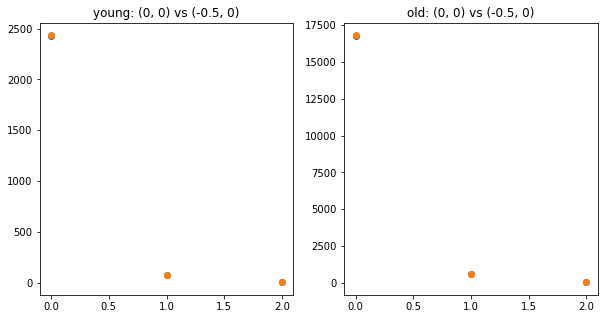

0    2432
1      74
2       8
Name: transit_multiplicity, dtype: int64
0    2434
1      77
2       3
Name: transit_multiplicity, dtype: int64
0    16779
1      636
2       40
Name: transit_multiplicity, dtype: int64
0    16794
1      610
2       51
Name: transit_multiplicity, dtype: int64


In [134]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=[10,5])
ax = axes[0]
ax.scatter(a_young.transit_multiplicity.value_counts().index, a_young.transit_multiplicity.value_counts())
ax.scatter(b_young.transit_multiplicity.value_counts().index, b_young.transit_multiplicity.value_counts())
ax.set_title('young: (0, 0) vs (-0.5, 0)')

ax = axes[1]
ax.scatter(a_old.transit_multiplicity.value_counts().index, a_old.transit_multiplicity.value_counts())
ax.scatter(b_old.transit_multiplicity.value_counts().index, b_old.transit_multiplicity.value_counts())
ax.set_title('old: (0, 0) vs (-0.5, 0)')
plt.show()

print(a_young.transit_multiplicity.value_counts())
print(b_young.transit_multiplicity.value_counts())
print(a_old.transit_multiplicity.value_counts())
print(b_old.transit_multiplicity.value_counts())

In [135]:
a.loc[a.star_ages < 0.5] # these are the stars with non-zero P(intact) in the (-1, 0.5) case; ~1% of FGK stars

,Unnamed: 0,star_ages,planet_periods,semi_major_axes,midplane,midplane_degrees,planet_inclinations,planet_inclinations_degrees,impact_parameters,transit_status,...,geometric_transit_multiplicity,transit_multiplicity,kepid,y_intercept,slope,transit_duration,6hr_cdpp,signal_noise,prob_detections,num_planets
68,68,0.27,[24.056313462842],[0.17490502930107377],0.942064,[53.976278940176684],[1.021091460356562],[58.50423117528081],[26.949075371003726],[0],...,0,0,1571732,0.0,-0.1,[nan],134.900,[nan],[0.],1
93,93,0.26,"[9.283717718615172, 8.385534195037323]","[0.09100168449528516, 0.08503322222657744]",-0.725519,[-41.56917276426464],"[-0.7467739491744805, -0.9724513660469886]","[-42.78699553801478, -55.71735905622397]","[-11.99660163377752, -13.635573981206552]","[0, 0]",...,0,0,1718753,0.0,-0.1,[nan nan],44.813,[nan nan],[0. 0.],2
111,111,0.46,[3.8762205704039423],[0.05237215055227085],0.251237,[14.394831329657192],[0.14348016637906463],[8.220807977355255],[1.2780083748714284],[0],...,0,0,1722816,0.0,-0.1,[nan],85.155,[nan],[0.],1
217,217,0.35,[19.919736102057566],[0.15895908892577135],-0.780076,[-44.695063886119975],[-0.9241391195827899],[-52.949271235029556],[-20.745375553918738],[0],...,0,0,2019761,0.0,-0.1,[nan],163.566,[nan],[0.],1
430,430,0.48,"[4.520526162354457, 17.4392675330878]","[0.06000390629679302, 0.1475952427322614]",-0.505886,[-28.985140819512466],"[-0.5354310260912153, -0.7199684436184478]","[-30.6779380153857, -41.25115320193962]","[-4.705604194686802, -14.958255964674002]","[0, 0]",...,0,0,2452289,0.0,-0.1,[nan nan],55.937,[nan nan],[0. 0.],2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19433,19433,0.30,[248.59286615193187],[0.8349274286118096],-1.159720,[-66.447089460137],[-1.1099083085667],[-63.59306172737579],[-132.67569424482198],[0],...,0,0,12024098,0.0,-0.1,[nan],35.270,[nan],[0.],1
19517,19517,0.29,"[15.268834424000126, 197.4541085243137]","[0.13066083153034858, 0.7198670198423942]",0.938251,[53.75782080737317],"[1.0648025903364235, 1.1244340645462767]","[61.00869444087465, 64.42532623924245]","[19.94773485129737, 113.33459129265023]","[0, 0]",...,0,0,12107925,0.0,-0.1,[nan nan],31.147,[nan nan],[0. 0.],2
19658,19658,0.47,"[275.6384419947161, 24.856157366927228]","[0.844765895833248, 0.1698761884821375]",0.827832,[47.43129387681254],"[0.8489224585380318, 0.8894263118017156]","[48.63967400809884, 50.96037385412511]","[136.34210037359796, 28.372316596866057]","[0, 0]",...,0,0,12215836,0.0,-0.1,[nan nan],57.862,[nan nan],[0. 0.],2
19672,19672,0.25,"[24.226570802111667, 182.12250236939394]","[0.17487068724274407, 0.6710653153566795]",-0.585802,[-33.56396784604226],"[-0.5428731634028716, -0.23185615756417982]","[-31.104341073900446, -13.28437928254772]","[-16.631451733202006, -28.388706207237707]","[0, 0]",...,0,0,12251653,0.0,-0.1,[nan nan],54.232,[nan nan],[0. 0.],2


In [136]:
print(a.y_intercept[0], a.slope[0])
print(b.y_intercept[0], b.slope[0])

0.0 -0.1
0.0 -1.0
